# Analysis

1. [Import Libraries](#libraries)
    1. [Custom Functions](#functions)
2. [Import Data](#data)
    1. [Convert to DataLoader](#convert)
3. [Build Model](#model)
    1. [Hyperparameters](#hyperparameters)
    2. [MLP](#mlp)
4. [Experiments](#experiments)
    1. [ReLU](#relu)
    2. [Tanh](#tanh)
    3. [ELU](#elu)
    4. [Leaky ReLU](#leaky)
5. [Analysis](#analysis)
    1. [Accuracy](#accuracy)
    2. [Selection Rate and Impact](#selection)

## Import Libraries<a id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics

from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [4]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [5]:
import timeit
import researchpy as rp

In [6]:
%matplotlib inline

In [7]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

## Custom Functions <a id="functions"></a>

#### Dataset class for pytorch dataloader

In [8]:
class dataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data, dtype=torch.float32, device=device)
        self.y = torch.tensor(target, dtype=torch.float32, device=device)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

#### Training function

In [9]:
def train(data, model, criterion, metric, optimizer):
    size = len(data.dataset)
    batches = len(data)
    running_loss = []
    acc = 0.0
    correct = 0
    predictions = []
    actuals = []
    loss = 0.0
    acc = 0.0
    current = 0
    
    for batch, (X, y) in enumerate(data,1):
        
        # forward step
        optimizer.zero_grad() # zero out the gradients
        y_hat = model(X)  #forward pass
        
        y = y.unsqueeze(-1) # reduce dimensions of tensor from [256, 1] to [256]
        
        loss = criterion(y_hat, y)  # calculate loss
       
        #  backprop step
        loss.backward()       # backward pass through model; computes gradients
        optimizer.step()      # update weights
        
        # metrics
        y = y.int()
        acc = metric(y_hat, y)

        y_hat = y_hat.cpu().detach().numpy()
        y_hat = y_hat.reshape(-1)
        
        y = y.cpu().detach().numpy()
        y = y.reshape(-1)
        
        predictions.append(y_hat)
        actuals.append(y)
            
        running_loss.append(loss.item())
    
        ## every 50 batches, store the results
        #if batch % 50 == 0:
        #    current = batch * len(X)
        
    print(f"\tTraining\tAccuracy: {acc:1.10f}\tLoss: {loss:1.10f}")
    
    return predictions, actuals, running_loss

#### Test function

In [10]:
def test(data, model, criterion, metric):
    size = len(data.dataset)
    batches = len(data)
    tst_loss = 0
    correct = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X, y in data:
            y_hat = model(X)
            y = y.unsqueeze(-1)
            tst_loss += criterion(y_hat, y).item()
            
            y = y.int()
            acc = metric(y_hat, y)
            
            y_hat = y_hat.cpu().detach().numpy()
            y_hat = y_hat.reshape(-1)
        
            y = y.cpu().detach().numpy()
            y = y.reshape(-1)
        
            predictions.append(y_hat)
            actuals.append(y)
            
    tst_loss /= batches
    correct /= size
    
    print(f"\tTest error\tAccuracy: {acc:1.10f}\tLoss: {tst_loss:1.10f}")
    return predictions, actuals

#### Function to flatten lists

In [11]:
def flatten(thing):
    '''
    thing: a list
    
    flatten receives a multi-level list and flatten it down 2 layers
    '''
    #thing = [element for sublist in thing for element in sublist]
    return [element for sublist in thing for element in sublist]

#### Metrics scoring

In [12]:
def f1_metrics(y_hat, y):
    '''
    f1_metrics(y_hat, y) returns a list of the metrics from the input lists or series
    
    y_hat : list or series, predicted labels
    y     : list or series, true/real labels
    '''

    tmp_metrics = []
    for n_iter, (predictions, actuals) in enumerate(list(zip(y_hat, y))):
        TP, TN = 0, 0
        FP, FN = 0, 0
        for i, j in list(zip(np.round(predictions), actuals)):
            if (i == j) and (i == 1):
                TP += 1
            elif (i == j) and (i == 0):
                TN += 1
            elif (i != j) and (i == 1):
                FP += 1
            elif (i != j) and (i == 0):
                FN += 1

        tmp_metrics.append((TP,TN,FP,FN))
        
    return tmp_metrics

#### Additional Functions

In [13]:
# activation functions
elu = nn.ELU()
leaky = nn.LeakyReLU()
relu = nn.ReLU()
tanh = nn.Tanh()
sigmoid = nn.Sigmoid()

# loss functions
mse = nn.MSELoss()
bce = nn.BCELoss()
kld = nn.KLDivLoss()

# optimizers
adam = torch.optim.Adam
sgd = torch.optim.SGD

#### Seed the RNG for the experiments

In [14]:
# random seed for consistency in pytorch and numpy
SEED = 23

torch.manual_seed(SEED)
np.random.seed(SEED)

#### Set device to CUDA, if available

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data<a id="data"></a>

#### Uncomment next when using google colab

In [16]:
french_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/french.parquet?raw=true")
# adult_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/adult.parquet?raw=true")
# loans_df = pd.read_parquet("https://github.com/ollin23/bias/blob/main/loans.parquet?raw=true")

#### Use the following cell if the data is stored locally

In [17]:
#french_df = pd.read_parquet("french.parquet")
#adult_df = pd.read_parquet("adult.parquet")
#loans_df = pd.read_parquet("loans.parquet")

#### Peak the data

##### FrenchC2C

In [18]:
french_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Columns: 224 entries, socialNbFollowers to language_it
dtypes: bool(4), float64(2), int64(218)
memory usage: 166.4 MB


In [19]:
french_df.shape

(98913, 224)

In [20]:
french_df.head()

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsMonths,target,civGen_1,civGen_2,civGen_3,gender_F,gender_M,countryCode_ad,countryCode_ae,countryCode_af,countryCode_ag,countryCode_ai,countryCode_al,countryCode_am,countryCode_an,countryCode_ao,countryCode_aq,countryCode_ar,countryCode_as,countryCode_at,countryCode_au,countryCode_aw,countryCode_az,countryCode_ba,countryCode_bb,countryCode_bd,countryCode_be,countryCode_bf,countryCode_bg,countryCode_bh,countryCode_bj,countryCode_bl,countryCode_bm,countryCode_bn,countryCode_bo,countryCode_br,countryCode_bs,countryCode_bv,countryCode_bw,countryCode_by,countryCode_bz,countryCode_ca,countryCode_cd,countryCode_cf,countryCode_cg,countryCode_ch,countryCode_ci,countryCode_cl,countryCode_cm,countryCode_cn,countryCode_co,countryCode_cr,countryCode_cu,countryCode_cy,countryCode_cz,countryCode_de,countryCode_dj,countryCode_dk,countryCode_dm,countryCode_do,countryCode_dz,countryCode_ec,countryCode_ee,countryCode_eg,countryCode_er,countryCode_es,countryCode_et,countryCode_fi,countryCode_fj,countryCode_fk,countryCode_fo,countryCode_fr,countryCode_ga,countryCode_gb,countryCode_gd,countryCode_ge,countryCode_gg,countryCode_gh,countryCode_gi,countryCode_gm,countryCode_gn,countryCode_gp,countryCode_gr,countryCode_gs,countryCode_gt,countryCode_gu,countryCode_gy,countryCode_hk,countryCode_hn,countryCode_hr,countryCode_ht,countryCode_hu,countryCode_ic,countryCode_id,countryCode_ie,countryCode_il,countryCode_im,countryCode_in,countryCode_iq,countryCode_ir,countryCode_is,countryCode_it,countryCode_je,countryCode_jm,countryCode_jo,countryCode_jp,countryCode_ke,countryCode_kg,countryCode_kh,countryCode_ki,countryCode_kn,countryCode_kp,countryCode_kr,countryCode_kw,countryCode_ky,countryCode_kz,countryCode_la,countryCode_lb,countryCode_lc,countryCode_li,countryCode_lk,countryCode_lt,countryCode_lu,countryCode_lv,countryCode_ly,countryCode_ma,countryCode_mc,countryCode_md,countryCode_mg,countryCode_mk,countryCode_ml,countryCode_mm,countryCode_mn,countryCode_mo,countryCode_mq,countryCode_mr,countryCode_mt,countryCode_mu,countryCode_mv,countryCode_mx,countryCode_my,countryCode_na,countryCode_nc,countryCode_ne,countryCode_nf,countryCode_ng,countryCode_ni,countryCode_nl,countryCode_no,countryCode_np,countryCode_nz,countryCode_om,countryCode_pa,countryCode_pe,countryCode_pf,countryCode_ph,countryCode_pk,countryCode_pl,countryCode_pr,countryCode_pt,countryCode_pw,countryCode_py,countryCode_qa,countryCode_re,countryCode_ro,countryCode_rs,countryCode_ru,countryCode_rw,countryCode_sa,countryCode_se,countryCode_sg,countryCode_si,countryCode_sj,countryCode_sk,countryCode_sn,countryCode_sr,countryCode_sv,countryCode_sy,countryCode_sz,countryCode_tc,countryCode_td,countryCode_tg,countryCode_th,countryCode_tj,countryCode_tn,countryCode_tr,countryCode_tt,countryCode_tw,countryCode_tz,countryCode_ua,countryCode_ug,countryCode_um,countryCode_us,countryCode_uy,countryCode_uz,countryCode_vc,countryCode_ve,countryCode_vg,countryCode_vi,countryCode_vn,countryCode_vu,countryCode_ws,countryCode_yt,countryCode_za,countryCode_zm,countryCode_zw,language_de,language_en,language_es,language_fr,language_it
0,147,10,77,26,174,74.0,104,1,True,False,True,True,11,106.53,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,167,8,2,19,170,99.0,0,0,True,False,True,True,12,106.80,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Convert <a id="convert"></a>

#### Split into train and test sets

In [27]:
french_X = french_df.drop(["gender_M", "target"], axis=1).values.astype(np.float32)
french_y = french_df.target.values.astype(np.float32)

In [28]:
fX_train, fX_test, fY_train, fY_test = train_test_split(french_X, french_y, test_size=0.3,
                                                        random_state=SEED, stratify=french_y)

In [29]:
fX_train.shape

(69239, 222)

In [30]:
adult_X = adult_df.drop(["sex_ Male", "target"], axis=1).values.astype(np.float32)
adult_y = adult_df.target.values.astype(np.float32)

In [31]:
loans_X = loans_df.drop("target", axis=1).values.astype(np.float32)
loans_y = loans_df.target.values.astype(np.float32)

#### Make datasets

In [32]:
french_trng_data = dataset(fX_train, fY_train)
french_test_data = dataset(fX_test, fY_test)

##### Construct test results dataframe for persistent storage

In [33]:
french_features= list(french_df.drop(["gender_M", "target"], axis=1).columns)
fr_test_df = pd.DataFrame(fX_test, columns=french_features)
fr_test_df.rename({"gender_F": "gender"}, axis=1, inplace=True)
fr_test_df["target"] = fY_test

##### Note
For this dataset: Female == 1, Male == 0

## Model<a id="model"></a>

#### MLP <a id="mlp"></a>

In [34]:
class MLP(nn.Module):
    
    def __init__(self, in_size, hidden1=relu, hidden2=relu, hidden3=relu, out_layer=sigmoid):
        super(MLP, self).__init__()
        
        # construct model dependent on size of inputs
        out1_2 = 2*in_size // 3
        out2_3 = 2*out1_2 // 3
        out3_4 = 2*out2_3 // 3

        self.linear_stack = nn.Sequential(
            nn.Linear(in_size, out1_2),
            hidden1,
            nn.Linear(out1_2, out2_3),
            hidden2,
            nn.Linear(out2_3, out3_4),
            hidden3,
            nn.Linear(out3_4, 1),
            out_layer
        )
        
    def forward(self, x):
        out = self.linear_stack(x)

        return out

# Experiments <a id="experiments"></a>

## Trial 1 - ReLU <a id="relu"></a>

#### Hyperparameters <a id="hyperparameters"></a>

In [35]:
alpha = 1e-5 # 0.00001
epochs = 50
batches = 256
hidden1 = relu
hidden2 = relu
hidden3 = relu
out_layer = sigmoid

#### DataLoader

In [36]:
# Helper function to feed data into pytorch neural network, only needs to execute once

fr_training_dl = DataLoader(french_trng_data, batch_size=batches)
fr_testing_dl = DataLoader(french_test_data, batch_size=batches)

#### Construct Model

In [37]:
# instantiate model
fr_relu = MLP(french_X.shape[1], hidden1, hidden2, hidden3, out_layer).to(device)

# select optimizing function
optimizer = adam(fr_relu.parameters(), lr=alpha)

# select loss function
criterion = bce

# accuracy metric
metric = torchmetrics.functional.accuracy

# display model
print(fr_relu.parameters)

<bound method Module.parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=222, out_features=148, bias=True)
    (1): ReLU()
    (2): Linear(in_features=148, out_features=98, bias=True)
    (3): ReLU()
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): ReLU()
    (6): Linear(in_features=65, out_features=1, bias=True)
    (7): Sigmoid()
  )
)>


#### Train and test

In [38]:
training_results = []
training_actuals = []
training_losses = []

testing_results = []
testing_actuals = []


start = timeit.default_timer()
for epoch in range(1,epochs+1):
    print (f"Epoch {epoch} / {epochs}")
    
    trng_result, trng_actual, trng_loss = train(fr_training_dl, fr_relu, criterion, metric, optimizer)
    tst_result, tst_actual = test(fr_testing_dl, fr_relu, criterion, metric)

    training_results.append(trng_result)
    training_actuals.append(trng_actual)
    training_losses.append(trng_loss)
    testing_results.append(tst_result)
    testing_actuals.append(tst_actual)
    
print("Finished")
print("* " * 30)
stop = timeit.default_timer()
print(f"Execution time (in seconds): {stop - start}")

Epoch 1 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2619740069
	Test error	Accuracy: 0.9829059839	Loss: 0.2020611123
Epoch 2 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2525250912
	Test error	Accuracy: 0.9786324501	Loss: 0.1724695242
Epoch 3 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2554808557
	Test error	Accuracy: 0.9786324501	Loss: 0.1693392077
Epoch 4 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2547386885
	Test error	Accuracy: 0.9829059839	Loss: 0.1678964620
Epoch 5 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2540018857
	Test error	Accuracy: 0.9829059839	Loss: 0.1668249118
Epoch 6 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2532825768
	Test error	Accuracy: 0.9829059839	Loss: 0.1659505111
Epoch 7 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2528990507
	Test error	Accuracy: 0.9829059839	Loss: 0.1652139291
Epoch 8 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2521348596
	Test error	Accuracy: 0.9829059839	Loss: 0.1644714626
Epoch 9 / 50
	Training	Accuracy: 0.9159663916	Lo

### Prepare results for analysis

In [39]:
fr_trng_preds = [[] for _ in range(len(training_results))]
fr_trng_actual = [[] for _ in range(len(training_actuals))]

fr_tst_preds = [[] for _ in range(len(testing_results))]
fr_tst_actual = [[] for _ in range(len(testing_actuals))]

In [40]:
for i in range(len(training_results)):
    fr_trng_preds[i] = flatten(training_results[i])
    fr_trng_actual[i] = flatten(training_actuals[i])
    
    fr_tst_preds[i] = flatten(testing_results[i])
    fr_tst_actual[i] = flatten(testing_actuals[i])

#### ReLU Metrics for Tensorboard <a id="relu-metrics-for-tensorboard"></a>

In [41]:
fr_acc_trng_relu = []
fr_acc_tst_relu = []
fr_loss_relu = []


writer = SummaryWriter(log_dir="Analysis_v2_FrenchC2C")

for i in range(len(fr_trng_preds)):
    y_hat = np.array(np.round(fr_trng_preds[i]))
    y = np.array(fr_trng_actual[i])

    y_hat_tst = np.array(np.round(fr_tst_preds[i]))
    y_tst = np.array(fr_tst_actual[i])
    trng_acc = (y_hat == fr_trng_actual[i]).sum()/len(fr_trng_preds[i])
    test_acc = (y_hat_tst == y_tst).sum()/len(fr_tst_preds[i])
    
    avg_loss = np.average(training_losses[i])
    
    fr_acc_trng_relu.append(trng_acc)
    fr_acc_tst_relu.append(test_acc)
    fr_loss_relu.append(avg_loss)
    writer.add_scalar("Training Accuracy ReLU (FrenchC2C)", trng_acc, i)
    writer.add_scalar("Test Accuracy ReLU (FrenchC2C)", test_acc, i)
    writer.add_scalar("Training Loss ReLU (FrenchC2C)", avg_loss, i)
    writer.add_pr_curve("Precision-Recall Curve ReLU (FrenchC2C)", y_tst, y_hat_tst, i)

t, _ = next(iter(french_trng_data))
writer.add_graph(fr_relu, t)

writer.close()

#### Calculate the recall, precision, etc from the above

In [42]:
fr_metrics_relu = f1_metrics(fr_tst_preds, fr_tst_actual)
TP, TN, FP, FN = fr_metrics_relu[-1]

accuracy_relu = (TP + TN)/(TP+TN+FP+FN)
precision_relu = TP/ (TP+FP)
recall_relu = TP / (TP + FN)
f1_score_relu = (2 * precision_relu * recall_relu)/(precision_relu + recall_relu)

#### Add ReLU predictions to persistent storage

In [43]:
fr_test_df["pred_relu"] = np.array(np.round(fr_tst_preds[-1]))

## Trial 2 - Tanh <a id="tanh"></a>

#### Hyperparameters

In [44]:
alpha = 1e-5 # 0.00001
epochs = 50
batches = 256
hidden1 = tanh
hidden2 = tanh
hidden3 = tanh
out_layer = sigmoid

#### Construct model

In [45]:
# instantiate model
fr_tanh = MLP(french_X.shape[1], hidden1, hidden2, hidden3, out_layer).to(device)

# select optimizing function
optimizer = adam(fr_tanh.parameters(), lr=alpha)

# select loss function
criterion = bce

# accuracy metric
metric = torchmetrics.functional.accuracy

# display model
print(fr_tanh.parameters)

<bound method Module.parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=222, out_features=148, bias=True)
    (1): Tanh()
    (2): Linear(in_features=148, out_features=98, bias=True)
    (3): Tanh()
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): Tanh()
    (6): Linear(in_features=65, out_features=1, bias=True)
    (7): Sigmoid()
  )
)>


#### Training and test

In [46]:
training_results = []
training_actuals = []
training_losses = []

testing_results = []
testing_actuals = []


start = timeit.default_timer()
for epoch in range(1,epochs+1):
    print (f"Epoch {epoch} / {epochs}")
    
    trng_result, trng_actual, trng_loss = train(fr_training_dl, fr_tanh, criterion, metric, optimizer)
    tst_result, tst_actual = test(fr_testing_dl, fr_tanh, criterion, metric)

    training_results.append(trng_result)
    training_actuals.append(trng_actual)
    training_losses.append(trng_loss)
    testing_results.append(tst_result)
    testing_actuals.append(tst_actual)
    
print("Finished")
print("* " * 30)
stop = timeit.default_timer()
print(f"Execution time (in seconds): {stop - start}")

Epoch 1 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.3536731303
	Test error	Accuracy: 0.9786324501	Loss: 0.3182582781
Epoch 2 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2746672332
	Test error	Accuracy: 0.9786324501	Loss: 0.2240988263
Epoch 3 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2539709508
	Test error	Accuracy: 0.9786324501	Loss: 0.1944454131
Epoch 4 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2482100129
	Test error	Accuracy: 0.9786324501	Loss: 0.1830622994
Epoch 5 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2463838458
	Test error	Accuracy: 0.9786324501	Loss: 0.1777222981
Epoch 6 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2453955114
	Test error	Accuracy: 0.9786324501	Loss: 0.1746360556
Epoch 7 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2446038723
	Test error	Accuracy: 0.9829059839	Loss: 0.1725293054
Epoch 8 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2438872159
	Test error	Accuracy: 0.9829059839	Loss: 0.1708234812
Epoch 9 / 50
	Training	Accuracy: 0.9159663916	Lo

#### Prepare tanh results for analysis

In [47]:
fr_trng_preds = [[] for _ in range(len(training_results))]
fr_trng_actual = [[] for _ in range(len(training_actuals))]

fr_tst_preds = [[] for _ in range(len(testing_results))]
fr_tst_actual = [[] for _ in range(len(testing_actuals))]

for i in range(len(training_results)):
    fr_trng_preds[i] = flatten(training_results[i])
    fr_trng_actual[i] = flatten(training_actuals[i])
    
    fr_tst_preds[i] = flatten(testing_results[i])
    fr_tst_actual[i] = flatten(testing_actuals[i])

In [48]:
fr_acc_trng_tanh = []
fr_acc_tst_tanh = []
fr_loss_tanh = []


writer = SummaryWriter(log_dir="Analysis_v2_FrenchC2C")

for i in range(len(fr_trng_preds)):
    y_hat = np.array(np.round(fr_trng_preds[i]))
    y = np.array(fr_trng_actual[i])

    y_hat_tst = np.array(np.round(fr_tst_preds[i]))
    y_tst = np.array(fr_tst_actual[i])
    trng_acc = (y_hat == fr_trng_actual[i]).sum()/len(fr_trng_preds[i])
    test_acc = (y_hat_tst == y_tst).sum()/len(fr_tst_preds[i])
    
    avg_loss = np.average(training_losses[i])
    
    fr_acc_trng_tanh.append(trng_acc)
    fr_acc_tst_tanh.append(test_acc)
    fr_loss_tanh.append(avg_loss)
    writer.add_scalar("Training Accuracy Tanh (FrenchC2C)", trng_acc, i)
    writer.add_scalar("Test Accuracy Tanh (FrenchC2C)", test_acc, i)
    writer.add_scalar("Training Loss Tanh (FrenchC2C)", avg_loss, i)
    writer.add_pr_curve("Precision-Recall Curve Tanh (FrenchC2C)", y_tst, y_hat_tst, i)

t, _ = next(iter(french_trng_data))
writer.add_graph(fr_tanh, t)

writer.close()

In [49]:
fr_metrics_tanh = f1_metrics(fr_tst_preds, fr_tst_actual)
TP, TN, FP, FN = fr_metrics_tanh[-1]

accuracy_tanh = (TP + TN)/(TP+TN+FP+FN)
precision_tanh = TP/ (TP+FP)
recall_tanh = TP / (TP + FN)
f1_score_tanh = (2 * precision_tanh * recall_tanh)/(precision_tanh + recall_tanh)

In [50]:
fr_test_df["pred_tanh"] = np.array(np.round(fr_tst_preds[-1]))

## Trial 3 - ELU <a id="elu"></a>

#### Hyperparameters

In [51]:
alpha = 1e-5 # 0.00001
epochs = 50
batches = 256
hidden1 = elu
hidden2 = elu
hidden3 = elu
out_layer = sigmoid

#### Construct model

In [52]:
# instantiate model
fr_elu = MLP(french_X.shape[1], hidden1, hidden2, hidden3, out_layer).to(device)

# select optimizing function
optimizer = adam(fr_elu.parameters(), lr=alpha)

# select loss function
criterion = bce

# accuracy metric
metric = torchmetrics.functional.accuracy

# display model
print(fr_elu.parameters)

<bound method Module.parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=222, out_features=148, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=148, out_features=98, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=65, out_features=1, bias=True)
    (7): Sigmoid()
  )
)>


#### Train and test

In [53]:
training_results = []
training_actuals = []
training_losses = []

testing_results = []
testing_actuals = []


start = timeit.default_timer()
for epoch in range(1,epochs+1):
    print (f"Epoch {epoch} / {epochs}")
    
    trng_result, trng_actual, trng_loss = train(fr_training_dl, fr_elu, criterion, metric, optimizer)
    tst_result, tst_actual = test(fr_testing_dl, fr_elu, criterion, metric)

    training_results.append(trng_result)
    training_actuals.append(trng_actual)
    training_losses.append(trng_loss)
    testing_results.append(tst_result)
    testing_actuals.append(tst_actual)
    
print("Finished")
print("* " * 30)
stop = timeit.default_timer()
print(f"Execution time (in seconds): {stop - start}")

Epoch 1 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2576391399
	Test error	Accuracy: 0.9743589759	Loss: 0.1721004024
Epoch 2 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2553367615
	Test error	Accuracy: 0.9743589759	Loss: 0.1689499617
Epoch 3 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2537259459
	Test error	Accuracy: 0.9786324501	Loss: 0.1671487440
Epoch 4 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2516397834
	Test error	Accuracy: 0.9786324501	Loss: 0.1657131914
Epoch 5 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2505930960
	Test error	Accuracy: 0.9829059839	Loss: 0.1646334268
Epoch 6 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2488312721
	Test error	Accuracy: 0.9829059839	Loss: 0.1635705809
Epoch 7 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2474167645
	Test error	Accuracy: 0.9829059839	Loss: 0.1625994737
Epoch 8 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2464334220
	Test error	Accuracy: 0.9829059839	Loss: 0.1615692068
Epoch 9 / 50
	Training	Accuracy: 0.9159663916	Lo

#### Prepare ELU results for analysis

In [54]:
fr_trng_preds = [[] for _ in range(len(training_results))]
fr_trng_actual = [[] for _ in range(len(training_actuals))]

fr_tst_preds = [[] for _ in range(len(testing_results))]
fr_tst_actual = [[] for _ in range(len(testing_actuals))]

for i in range(len(training_results)):
    fr_trng_preds[i] = flatten(training_results[i])
    fr_trng_actual[i] = flatten(training_actuals[i])
    
    fr_tst_preds[i] = flatten(testing_results[i])
    fr_tst_actual[i] = flatten(testing_actuals[i])

In [55]:
fr_acc_trng_elu = []
fr_acc_tst_elu = []
fr_loss_elu = []


writer = SummaryWriter(log_dir="Analysis_v2_FrenchC2C")

for i in range(len(fr_trng_preds)):
    y_hat = np.array(np.round(fr_trng_preds[i]))
    y = np.array(fr_trng_actual[i])

    y_hat_tst = np.array(np.round(fr_tst_preds[i]))
    y_tst = np.array(fr_tst_actual[i])
    trng_acc = (y_hat == fr_trng_actual[i]).sum()/len(fr_trng_preds[i])
    test_acc = (y_hat_tst == y_tst).sum()/len(fr_tst_preds[i])
    
    avg_loss = np.average(training_losses[i])
    
    fr_acc_trng_elu.append(trng_acc)
    fr_acc_tst_elu.append(test_acc)
    fr_loss_elu.append(avg_loss)
    writer.add_scalar("Training Accuracy ELU (FrenchC2C)", trng_acc, i)
    writer.add_scalar("Test Accuracy ELU (FrenchC2C)", test_acc, i)
    writer.add_scalar("Training Loss ELU (FrenchC2C)", avg_loss, i)
    writer.add_pr_curve("Precision-Recall Curve ELU (FrenchC2C)", y_tst, y_hat_tst, i)

t, _ = next(iter(french_trng_data))
writer.add_graph(fr_elu, t)

writer.close()

#### Gather ELU Metrics

In [56]:
fr_metrics_elu = f1_metrics(fr_tst_preds, fr_tst_actual)
TP, TN, FP, FN = fr_metrics_elu[-1]

accuracy_elu = (TP + TN)/(TP+TN+FP+FN)
precision_elu = TP/ (TP+FP)
recall_elu = TP / (TP + FN)
f1_score_elu = (2 * precision_elu * recall_elu)/(precision_elu + recall_elu)

#### Add ELU test results to persistent storage

In [57]:
fr_test_df["pred_elu"] = np.array(np.round(fr_tst_preds[-1]))

## Trial 4 - Leaky ReLU <a id="leaky"></a>

#### Hyperparameters

In [58]:
alpha = 1e-5 # 0.00001
epochs = 50
batches = 256
hidden1 = leaky
hidden2 = leaky
hidden3 = leaky
out_layer = sigmoid

#### Construct Model

In [59]:
# instantiate model
fr_leaky = MLP(french_X.shape[1], hidden1, hidden2, hidden3, out_layer).to(device)

# select optimizing function
optimizer = adam(fr_leaky.parameters(), lr=alpha)

# select loss function
criterion = bce

# accuracy metric
metric = torchmetrics.functional.accuracy

# display model
print(fr_leaky.parameters)

<bound method Module.parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=222, out_features=148, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=148, out_features=98, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=65, out_features=1, bias=True)
    (7): Sigmoid()
  )
)>


#### Train and test

In [60]:
training_results = []
training_actuals = []
training_losses = []

testing_results = []
testing_actuals = []


start = timeit.default_timer()
for epoch in range(1,epochs+1):
    print (f"Epoch {epoch} / {epochs}")
    
    trng_result, trng_actual, trng_loss = train(fr_training_dl, fr_leaky, criterion, metric, optimizer)
    tst_result, tst_actual = test(fr_testing_dl, fr_leaky, criterion, metric)

    training_results.append(trng_result)
    training_actuals.append(trng_actual)
    training_losses.append(trng_loss)
    testing_results.append(tst_result)
    testing_actuals.append(tst_actual)
    
print("Finished")
print("* " * 30)
stop = timeit.default_timer()
print(f"Execution time (in seconds): {stop - start}")

Epoch 1 / 50
	Training	Accuracy: 0.9075630307	Loss: 0.2536746860
	Test error	Accuracy: 0.9743589759	Loss: 0.1801704786
Epoch 2 / 50
	Training	Accuracy: 0.9075630307	Loss: 0.2569854558
	Test error	Accuracy: 0.9743589759	Loss: 0.1721839760
Epoch 3 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2575205266
	Test error	Accuracy: 0.9743589759	Loss: 0.1704879117
Epoch 4 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2567542493
	Test error	Accuracy: 0.9743589759	Loss: 0.1692686674
Epoch 5 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2555820048
	Test error	Accuracy: 0.9786324501	Loss: 0.1681458847
Epoch 6 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2548653781
	Test error	Accuracy: 0.9786324501	Loss: 0.1672908287
Epoch 7 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2535601258
	Test error	Accuracy: 0.9829059839	Loss: 0.1664167162
Epoch 8 / 50
	Training	Accuracy: 0.9159663916	Loss: 0.2523578405
	Test error	Accuracy: 0.9829059839	Loss: 0.1656510242
Epoch 9 / 50
	Training	Accuracy: 0.9159663916	Lo

#### Prepare Leaky ReLU data for analysis

In [61]:
fr_trng_preds = [[] for _ in range(len(training_results))]
fr_trng_actual = [[] for _ in range(len(training_actuals))]

fr_tst_preds = [[] for _ in range(len(testing_results))]
fr_tst_actual = [[] for _ in range(len(testing_actuals))]

for i in range(len(training_results)):
    fr_trng_preds[i] = flatten(training_results[i])
    fr_trng_actual[i] = flatten(training_actuals[i])
    
    fr_tst_preds[i] = flatten(testing_results[i])
    fr_tst_actual[i] = flatten(testing_actuals[i])

In [62]:
fr_acc_trng_leaky = []
fr_acc_tst_leaky = []
fr_loss_leaky = []


writer = SummaryWriter(log_dir="Analysis_v2_FrenchC2C")

for i in range(len(fr_trng_preds)):
    y_hat = np.array(np.round(fr_trng_preds[i]))
    y = np.array(fr_trng_actual[i])

    y_hat_tst = np.array(np.round(fr_tst_preds[i]))
    y_tst = np.array(fr_tst_actual[i])
    trng_acc = (y_hat == fr_trng_actual[i]).sum()/len(fr_trng_preds[i])
    test_acc = (y_hat_tst == y_tst).sum()/len(fr_tst_preds[i])
    
    avg_loss = np.average(training_losses[i])
    
    fr_acc_trng_leaky.append(trng_acc)
    fr_acc_tst_leaky.append(test_acc)
    fr_loss_leaky.append(avg_loss)
    writer.add_scalar("Training Accuracy Leaky ReLU (FrenchC2C)", trng_acc, i)
    writer.add_scalar("Test Accuracy Leaky ReLU (FrenchC2C)", test_acc, i)
    writer.add_scalar("Training Loss Leaky ReLU (FrenchC2C)", avg_loss, i)
    writer.add_pr_curve("Precision-Recall Curve Leaky ReLU (FrenchC2C)", y_tst, y_hat_tst, i)

t, _ = next(iter(french_trng_data))
writer.add_graph(fr_leaky, t)

writer.close()

#### Gather Leaky ReLU metrics

In [63]:
fr_metrics_leaky = f1_metrics(fr_tst_preds, fr_tst_actual)
TP, TN, FP, FN = fr_metrics_leaky[-1]

accuracy_leaky = (TP + TN)/(TP+TN+FP+FN)
precision_leaky = TP/ (TP+FP)
recall_leaky = TP / (TP + FN)
f1_score_leaky = (2 * precision_leaky * recall_leaky)/(precision_leaky + recall_leaky)

#### Add Leaky ReLU data to persistent storage

In [64]:
fr_test_df["pred_leaky"] = np.array(np.round(fr_tst_preds[-1]))

In [86]:
fr_test_df.to_csv("frenchC2C_results.csv", index=False)

In [87]:
fr_test_df.to_parquet("frenchC2C_results.parquet")

# Analysis <a id="analysis"></a>

### Accuracy and Loss <a id="accuaracy"></a>

In [79]:
print("FrenchC2C Results")
print("\t\tReLU\tTanh\tELU\tLeaky")
print(f"Accuracy:\t{accuracy_relu:.4f}\t"\
      f"{accuracy_tanh:0.4f}\t{accuracy_elu:0.4f}\t{accuracy_leaky:0.4f}")
print(f"Precision:\t{precision_relu:0.4f}\t"\
      f"{precision_tanh:0.4f}\t{precision_elu:0.4f}\t{precision_leaky:0.4f}")
print(f"Recall:\t\t{recall_relu:0.4f}\t"\
      f"{recall_tanh:0.4f}\t{recall_elu:0.4f}\t{recall_leaky:0.4f}")
print(f"F1 Score:\t{f1_score_relu:0.4f}\t"\
      f"{f1_score_tanh:0.4f}\t{f1_score_elu:0.4f}\t{f1_score_leaky:0.4f}")

FrenchC2C Results
		ReLU	Tanh	ELU	Leaky
Accuracy:	0.9605	0.9965	0.9747	0.9566
Precision:	0.8450	0.9762	0.9442	0.7549
Recall:		0.3419	0.9594	0.5720	0.3087
F1 Score:	0.4869	0.9677	0.7124	0.4382
SR base (F):	0.0522
SR base (M):	0.0633
Impact:		0.8247


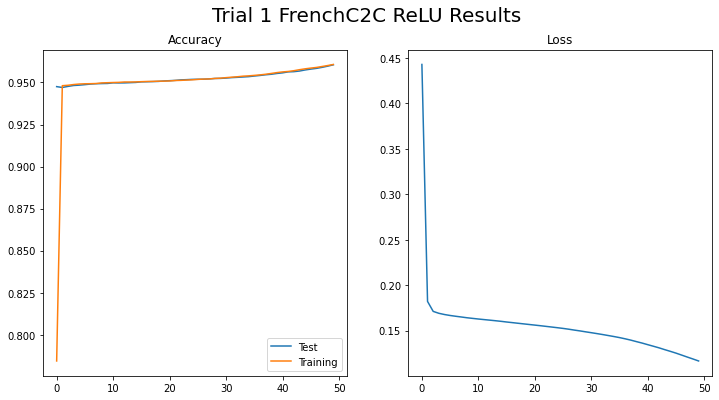

In [68]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

fig.suptitle("Trial 1 FrenchC2C ReLU Results", size=20)

axs[0].plot(fr_acc_tst_relu, label="Test")
axs[0].plot(fr_acc_trng_relu, label="Training")
axs[0].set_title("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(fr_loss_relu)
axs[1].set_title("Loss")

plt.show()

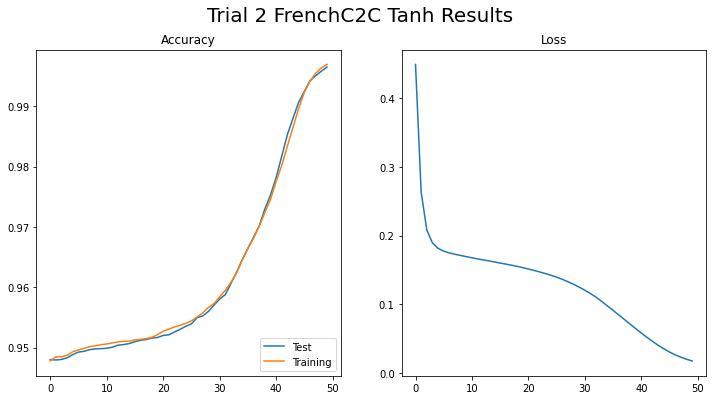

In [69]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

fig.suptitle("Trial 2 FrenchC2C Tanh Results", size=20)

axs[0].plot(fr_acc_tst_tanh, label="Test")
axs[0].plot(fr_acc_trng_tanh, label="Training")
axs[0].set_title("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(fr_loss_tanh)
axs[1].set_title("Loss")

plt.show()

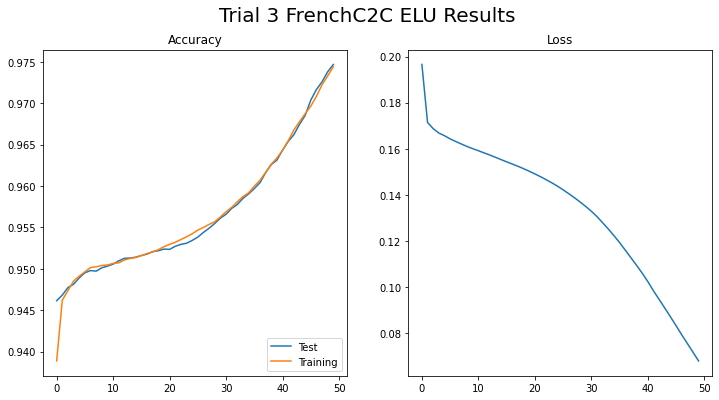

In [70]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

fig.suptitle("Trial 3 FrenchC2C ELU Results", size=20)

axs[0].plot(fr_acc_tst_elu, label="Test")
axs[0].plot(fr_acc_trng_elu, label="Training")
axs[0].set_title("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(fr_loss_elu)
axs[1].set_title("Loss")

plt.show()

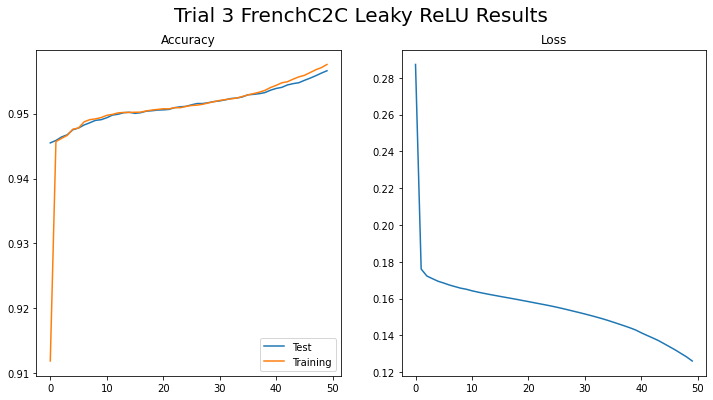

In [71]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

fig.suptitle("Trial 3 FrenchC2C Leaky ReLU Results", size=20)

axs[0].plot(fr_acc_tst_leaky, label="Test")
axs[0].plot(fr_acc_trng_leaky, label="Training")
axs[0].set_title("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(fr_loss_leaky)
axs[1].set_title("Loss")

plt.show()

### Selection rate and impact <a id="selection"></a>

#### Baseline

In [65]:
fr_females = fr_test_df[fr_test_df.gender == 1]
fr_males = fr_test_df[fr_test_df.gender == 0]

fr_selection_rate_f = float((fr_females[fr_females.target == 1].target.value_counts() / fr_females.target.value_counts().sum()).values)
fr_selection_rate_m = float((fr_males[fr_males.target == 1].target.value_counts() / fr_males.target.value_counts().sum()).values)
fr_impact = min(fr_selection_rate_f, fr_selection_rate_m)/max(fr_selection_rate_f, fr_selection_rate_m)

In [95]:
sr_f_relu = float((fr_females[fr_females.pred_relu == 1].pred_relu.value_counts() / fr_females.pred_relu.value_counts().sum()).values)
sr_m_relu = float((fr_males[fr_males.pred_relu == 1].pred_relu.value_counts() / fr_males.pred_relu.value_counts().sum()).values)
impact_relu = min(sr_f_relu, sr_m_relu)/max(sr_f_relu, sr_m_relu)

In [96]:
sr_f_tanh = float((fr_females[fr_females.pred_tanh == 1].pred_tanh.value_counts() / fr_females.pred_tanh.value_counts().sum()).values)
sr_m_tanh = float((fr_males[fr_males.pred_tanh == 1].pred_tanh.value_counts() / fr_males.pred_tanh.value_counts().sum()).values)
impact_tanh = min(sr_f_tanh, sr_m_tanh)/max(sr_f_tanh, sr_m_tanh)

In [97]:
sr_f_elu = float((fr_females[fr_females.pred_elu == 1].pred_elu.value_counts() / fr_females.pred_elu.value_counts().sum()).values)
sr_m_elu = float((fr_males[fr_males.pred_elu == 1].pred_elu.value_counts() / fr_males.pred_elu.value_counts().sum()).values)
impact_elu = min(sr_f_elu, sr_m_elu)/max(sr_f_elu, sr_m_elu)

In [98]:
sr_f_leaky = float((fr_females[fr_females.pred_leaky == 1].pred_leaky.value_counts() / fr_females.pred_leaky.value_counts().sum()).values)
sr_m_leaky = float((fr_males[fr_males.pred_leaky == 1].pred_leaky.value_counts() / fr_males.pred_leaky.value_counts().sum()).values)
impact_leaky = min(sr_f_leaky, sr_m_leaky)/max(sr_f_leaky, sr_m_leaky)

In [100]:
print("Selection Rate")
print("\t\tFemale\tMale\tImpact")
print(f"Baseline\t{fr_selection_rate_f:0.4f}\t{fr_selection_rate_m:0.4f}\t{fr_impact:0.4f}")
print(f"ReLU\t\t{sr_f_relu:0.4f}\t{sr_m_relu:0.4f}\t{impact_relu:0.4f}")
print(f"Tanh\t\t{sr_f_tanh:0.4f}\t{sr_m_tanh:0.4f}\t{impact_tanh:0.4f}")
print(f"ELU\t\t{sr_f_elu:0.4f}\t{sr_m_elu:0.4f}\t{impact_elu:0.4f}")
print(f"Leaky ReLU:\t{sr_f_leaky:0.4f}\t{sr_m_leaky:0.4f}\t{impact_leaky:0.4f}")

Selection Rate
		Female	Male	Impact
Baseline	0.0522	0.0633	0.8247
ReLU		0.0222	0.0220	0.9902
Tanh		0.0511	0.0627	0.8154
ELU		0.0311	0.0400	0.7781
Leaky ReLU:	0.0230	0.0204	0.8874
